![image](https://github.com/Lexie88rus/EF_Analysis/raw/master/assets/windmills.jpg)

_Photo by Dan Meyers on Unsplash_

# Emission Factor Analysis

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# import helper libraries
import json

# import geometry manipulation
from shapely.geometry import Point
import geopandas as gpd

# import data visualization
import folium

import bokeh
from bokeh.models import ColumnDataSource, LinearColorMapper
from bokeh.plotting import figure, show, reset_output, output_notebook
from bokeh.palettes import brewer
from bokeh.models import HoverTool
from bokeh.models import GeoJSONDataSource
from bokeh.tile_providers import STAMEN_TERRAIN

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# NO2 Emission Intro

# Analyze the Data

## Power Plant Data

Visualize the powerplant data:

In [2]:
# load the powerplant data into pandas dataframe
gppd = pd.read_csv('../input/ds4g-environmental-insights-explorer/eie_data/gppd/gppd_120_pr.csv')

In [3]:
'''
Preprocess the data:
add latitude and longitude as separate columns
'''
 
def get_latitude(geo):
    '''
    Helper function to parse the latitude from json
    '''
    coords = json.loads(geo) 
    return coords['coordinates'][0]

def get_longitude(geo):
    '''
    Helper function to parse the longitude from json
    '''
    coords = json.loads(geo) 
    return coords['coordinates'][1]

# get latitude and longitude as separate columns
gppd['latitude'] = gppd.apply(lambda row: get_latitude(row['.geo']), axis=1)
gppd['longitude'] = gppd.apply(lambda row: get_longitude(row['.geo']), axis=1)

In [4]:
# convert pandas dataframe into geopandas dataframe
gppd['geometry'] = gppd.apply(lambda row: Point(float(row.latitude), float(row.longitude)), axis=1)
geo_df = gpd.GeoDataFrame(gppd, geometry='geometry')
# change the projection to add basemap to the plot
geo_df.crs = {'init': 'epsg:4326'}
geo_df = geo_df.to_crs(epsg=3857)

In [5]:
def visualize_power_plants(geo_df):
    '''
    Helper function to visualize the powerplant map
    INPUT:
        geo_df - geopandas dataframe containing the data to visualize (with coordinates geometry)
    '''
    ppd_geosource = GeoJSONDataSource(geojson=geo_df.to_json())
    source = ColumnDataSource(geo_df[['latitude', 'longitude', 'name', 'estimated_generation_gwh', 'capacity_mw']])

    # Create figure object.
    p1 = figure(title = 'Map of Power Plants', 
               plot_height = 500,
               plot_width = 800, 
               toolbar_location = 'below',
               tools = "pan, wheel_zoom, box_zoom, reset")
    p1.xgrid.grid_line_color = None
    p1.ygrid.grid_line_color = None

    # add basemap
    p1.add_tile(STAMEN_TERRAIN)

    # plot powerplant locations as circles
    powerplants_map = p1.circle('x', 'y', source=ppd_geosource, color='red', size=10,
                          name='powerplants')

    # Create hover tool
    p1.add_tools(HoverTool(renderers = [powerplants_map],
                          tooltips = [('Name', '@name'),
                              ('Generation','@estimated_generation_gwh'),
                                    ('Capacity','@capacity_mw')]))

    
    try:
        reset_output()
        output_notebook()
        show(p1)  # angrily yells at me about single ownership
    except:
        output_notebook()
        show(p1)  # ...aaaaaaand we're back to happy inline plotting.

In [6]:
visualize_power_plants(geo_df)

Loading BokehJS ...

Visualize the tabular data:

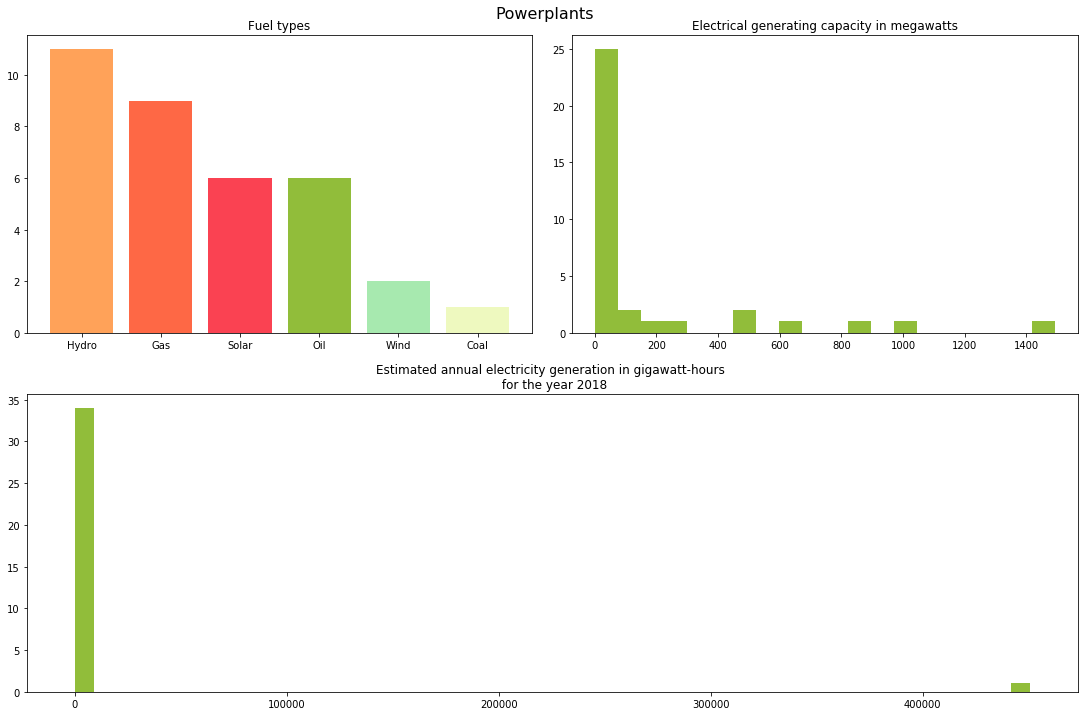

In [7]:
fig = plt.figure(constrained_layout=True, figsize=(15,10))
spec2 = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
ax1 = fig.add_subplot(spec2[0, 0])
ax2 = fig.add_subplot(spec2[0, 1])
ax3 = fig.add_subplot(spec2[1, :])

# 1. plot the fuel type bar chart
ax1.bar(range(gppd.primary_fuel.nunique()), gppd.primary_fuel.value_counts(), color=['#ffa259', '#fe6845', '#fa4252', '#91bd3a', '#a7e9af', '#eef9bf'])
ax1.set_xticks(range(gppd.primary_fuel.nunique()))
ax1.set_xticklabels(gppd.primary_fuel.value_counts().index)
ax1.set_title('Fuel types')

# 2. Histogram with capacity distribution
ax2.hist(gppd.capacity_mw, bins=20, color='#91bd3a')
ax2.set_title('Electrical generating capacity in megawatts')

# 3. Histogram with annual electricity generation
ax3.hist(gppd.estimated_generation_gwh, bins=50, color='#91bd3a')
ax3.set_title('Estimated annual electricity generation in gigawatt-hours \n for the year 2018')

plt.suptitle('Powerplants', fontsize=16)

plt.show()

There is a variety of different types of power plants of various capacitities and annual generation.

NO2 mostly comes from burning of fossil fuels: coal, oil and gas [5]. So let's look closer at Gas, Coal and Oil plants:

In [8]:
total_plants = len(gppd)
fossil_plants = len(gppd[(gppd.primary_fuel == 'Gas') | (gppd.primary_fuel == 'Oil') | (gppd.primary_fuel == 'Coal')])
print('1. {:.2f}% of plants are burning fossil fuels.'.format(fossil_plants / total_plants * 100))

total_capacity = gppd.capacity_mw.sum()
fossil_plants_capacity = gppd[(gppd.primary_fuel == 'Gas') | (gppd.primary_fuel == 'Oil') | (gppd.primary_fuel == 'Coal')].capacity_mw.sum()
print('2. Burning fossil fuels plants make {:.2f}% of total capacity.'.format(fossil_plants_capacity / total_capacity * 100))

total_generation = gppd.estimated_generation_gwh.sum()
fossil_plants_generation = gppd[(gppd.primary_fuel == 'Gas') | (gppd.primary_fuel == 'Oil') | (gppd.primary_fuel == 'Coal')].estimated_generation_gwh.sum()
print('3. Burning fossil fuels plants make {:.2f}% of estimated annual generation.'.format(fossil_plants_generation / total_generation * 100))

1. 45.71% of plants are burning fossil fuels.
2. Burning fossil fuels plants make 93.70% of total capacity.
3. Burning fossil fuels plants make 98.96% of estimated annual generation.


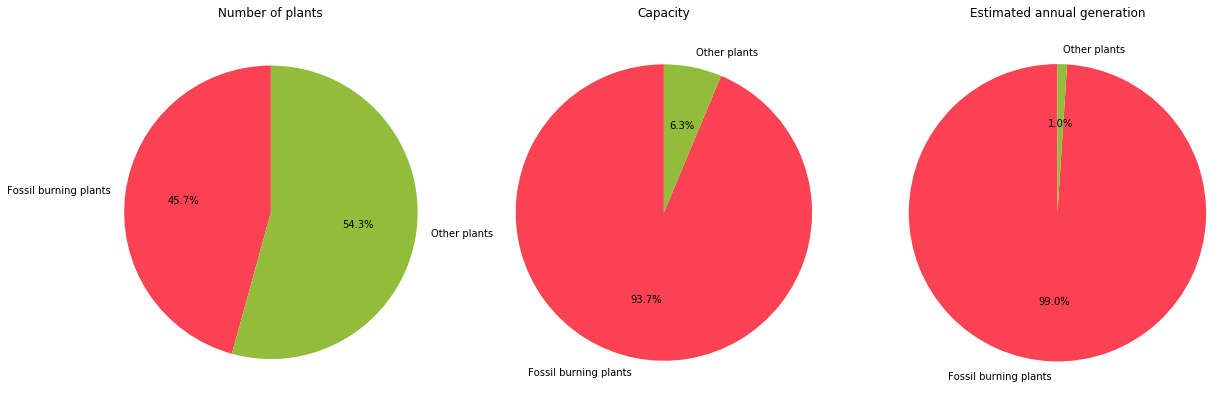

In [9]:
fig, axs = plt.subplots(1,3,figsize=(20,7))

axs[0].pie([fossil_plants, total_plants - fossil_plants], labels=['Fossil burning plants', 'Other plants'], autopct='%1.1f%%', 
           startangle=90, colors=['#fa4252', '#91bd3a'])
axs[0].axis('equal')
axs[0].set_title('Number of plants')

axs[1].pie([fossil_plants_capacity, total_capacity - fossil_plants_capacity], labels=['Fossil burning plants', 'Other plants'], 
           autopct='%1.1f%%', startangle=90, colors=['#fa4252', '#91bd3a'])
axs[1].axis('equal')
axs[1].set_title('Capacity')

axs[2].pie([fossil_plants_generation, total_generation - fossil_plants_generation], labels=['Fossil burning plants', 'Other plants'], 
           autopct='%1.1f%%', startangle=90, colors=['#fa4252', '#91bd3a'])
axs[2].axis('equal')
axs[2].set_title('Estimated annual generation')

plt.show()

The numbers tell us that though the most polluting power plants make only a half of the total number of plants, they produce the majority of the energy on the island.

## Resources
1. [Basic Information on EF](https://www.epa.gov/air-emissions-factors-and-quantification/basic-information-air-emissions-factors-and-quantification#About%20Emissions%20Factors)
2. [Procedures for development of EF](https://www3.epa.gov/ttn/chief/efpac/procedures/procedures81213.pdf)
3. [Emissions Estimations Tools](https://www.epa.gov/air-emissions-factors-and-quantification/emissions-estimation-tools)
4. [Greenhouse Gas Emissions Estimation Methodologies for Biogenic Emissions](https://www3.epa.gov/ttn/chief/efpac/ghg/GHG_Biogenic_Report_draft_Dec1410.pdf)
5. [Nitrogen Dioxide (NO2) Pollution](https://www.epa.gov/no2-pollution/basic-information-about-no2#What%20is%20NO2) and [Nitrogen dioxide (NO2) basic facts](https://www.environment.gov.au/protection/publications/factsheet-nitrogen-dioxide-no2), [NO2 and Health](https://ww2.arb.ca.gov/resources/nitrogen-dioxide-and-health)
6. [Mapped: nitrogen dioxide pollution around the world](https://unearthed.greenpeace.org/2018/10/29/nitrogen-dioxide-no2-pollution-world-map/)
7. [What are the greenhouse gas and air pollutant emissions factors for fuels and electricity?](https://www.eia.gov/tools/faqs/faq.php?id=76&t=11)
8. [United States Electricity Profile 2018](https://www.eia.gov/electricity/state/unitedstates/)
9. [Greenhouse Gases Equivalencies Calculator - Calculations and References](https://www.epa.gov/energy/greenhouse-gases-equivalencies-calculator-calculations-and-references)
10. [Emissions & Generation Resource Integrated Database](https://www.epa.gov/energy/emissions-generation-resource-integrated-database-egrid) and [eGRID Summary Tables 2018](https://www.epa.gov/sites/production/files/2020-01/documents/egrid2018_summary_tables.pdf)